In [308]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt


import pmdarima as pm
import statsmodels as st

from utils_time_series import *

In [309]:
ticker = "AAPL"
using_papermill = False

In [310]:
if not using_papermill:
    %load_ext autoreload
    %autoreload 2
    stocks = {}
    for file in os.listdir("stocks"):
        if ".parquet" in file:
            stock_name = file.rstrip(".parquet")
            df = pd.read_parquet(f"stocks/{file}")
            stocks[stock_name] = df
    print(stocks.keys())
    
    df = stocks[ticker]
else:
    df = pd.read_parquet(f"stocks/{ticker}.parquet")
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dict_keys(['AAPL', 'OXY', 'GS', 'MCD', 'MSFT', 'KHC', 'PEP'])


In [311]:
df_raw = df.copy()

df["Close_diff"] = df.Close.diff(1)
df = (df.set_index("date")
        .asfreq("D")
        .ffill()
        .bfill()
     )
#we fill saturdays and sundays with friday values

<AxesSubplot:xlabel='date', ylabel='Close'>

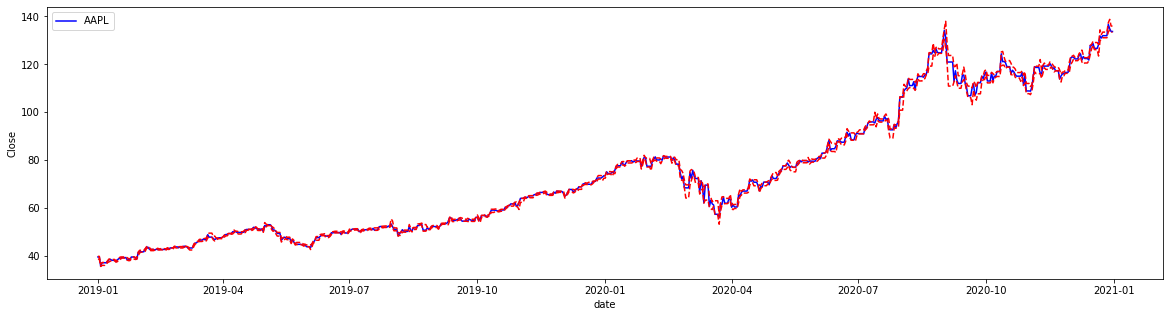

In [5]:
fig, ax = plt.subplots(figsize = (20, 5))
sns.lineplot(data = df, x = "date", y = "Close", color="blue", label=ticker, linestyle="-")
sns.lineplot(data = df, x = "date", y = "High", color="red", linestyle="dashed")
sns.lineplot(data = df, x = "date", y = "Low",  color="red", linestyle="dashed")


### Check for stationarity

In [6]:
stationary_test = pm.arima.ADFTest()
stationary_test.should_diff(df.Close)

(0.655026376961968, True)

(0.01, False)


<AxesSubplot:xlabel='date', ylabel='Close'>

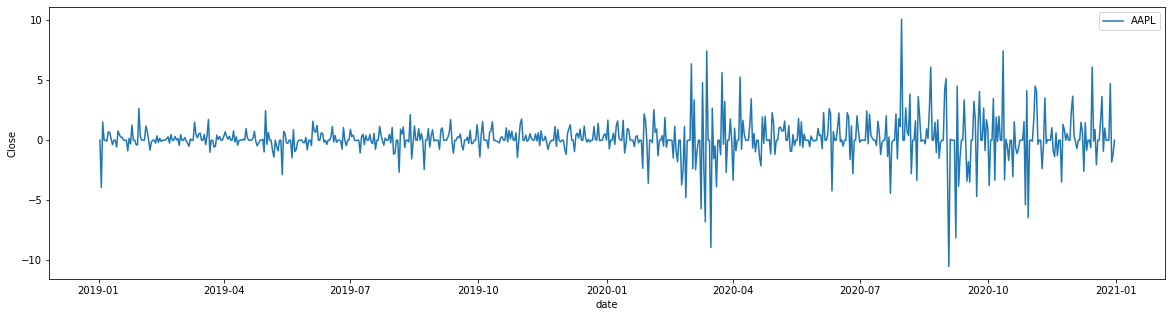

In [7]:
first_diff = df.Close.diff(periods = 1).dropna()
print(stationary_test.should_diff(first_diff))

fig, ax = plt.subplots(figsize = (20, 5))
sns.lineplot(data = first_diff, label=ticker, linestyle="-")


### Autocorrelation and partial-autocorrelation
* acf is used to determine MA order
* pacf is used to determine AR order

https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c#:~:text=The%20difference%20between%20ACF%20and,indicator%20of%20the%20significance%20threshold.

In [8]:
acf_p_values = pm.acf(first_diff)
pacf_p_values = pm.pacf(first_diff, method = "ols")

p_values_df = pd.DataFrame({"acf" : acf_p_values, "pacf" : pacf_p_values}).round(2)

In [9]:
(p_values_df[
    (p_values_df > 0.05).any(axis = 1)
].T
 .style
 .background_gradient(axis = None)
 .format(precision =2)
)

,0,7,9,11,13,20,21,24
acf,1.00,0.07,0.07,0.11,0.06,0.13,0.01,0.08
pacf,1.00,0.07,0.05,0.09,0.06,0.09,0.07,0.09


Figure(1080x720)
Figure(1080x720)


/Users/juanluis/opt/anaconda3/envs/tfm/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


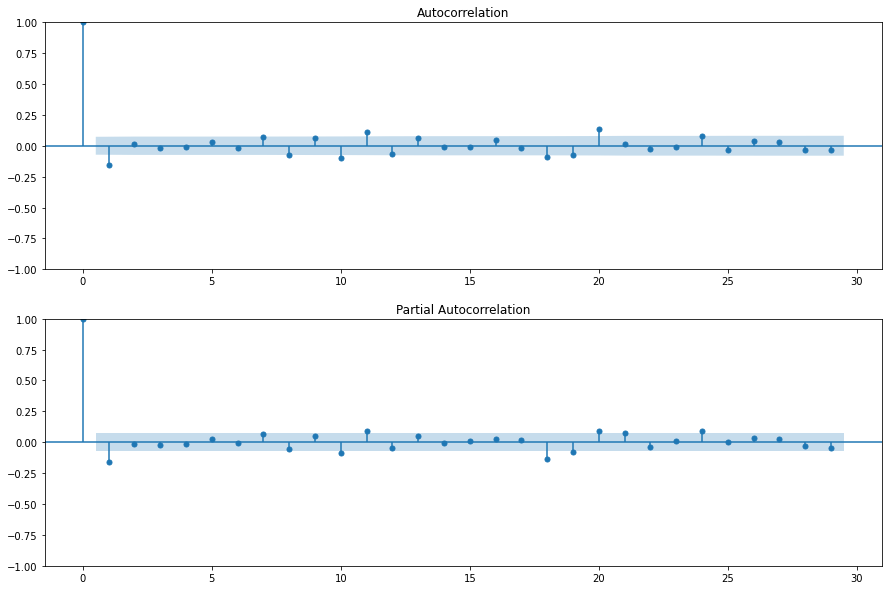

In [10]:
#first_diff = df.Close.diff(7).dropna()
fig, axes = plt.subplots(2,1, figsize = (15,10))
print(st.graphics.tsaplots.plot_acf(first_diff, ax = axes[0]))
print(st.graphics.tsaplots.plot_pacf(first_diff, ax = axes[1]))

In [160]:
errors = {}
threshold = '2020-09-30 23:59:00'

train_df, test_df = train_test_split(df, threshold, )#train_pctg = 0.85)


In [12]:
forecaster = fit_arima_model(train_df, exog_cols = None)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2336.766, Time=0.23 sec
First viable model found (2336.766)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2341.391, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2331.651, Time=0.03 sec
New best model found (2331.651 < 2336.766)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2331.011, Time=0.03 sec
New best model found (2331.011 < 2331.651)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2343.377, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2332.798, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2332.812, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2334.798, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2334.450, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.597 seconds


In [13]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  639
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1162.505
Date:                Wed, 03 May 2023   AIC                           2331.011
Time:                        19:59:48   BIC                           2344.386
Sample:                    01-01-2019   HQIC                          2336.203
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1194      0.051      2.320      0.020       0.019       0.220
ma.L1         -0.1426      0.026     -5.394      0.000      -0.194      -0.091
sigma2         2.2396      0.045     49.480      0.000       2.151       2.328
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5132.05
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              12.76   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test error (rmse): 2.0792709932157094


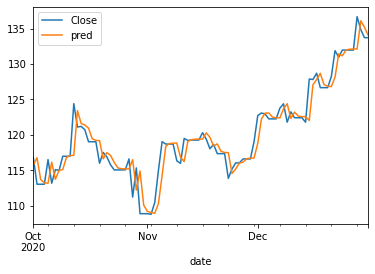

In [14]:
pred_df = predict_arima_ahead_update(forecaster, test_df, exog_cols = None)
errors["rsme_arima_close"] = compute_test_error(pred_df)

The arima model is clearly predicting the value of the previous day.

Lets see if we can add some exogenous variables from the news data

Test error (rmse): 2.3595054271527944
Test error (rmse): 4.806295636362065


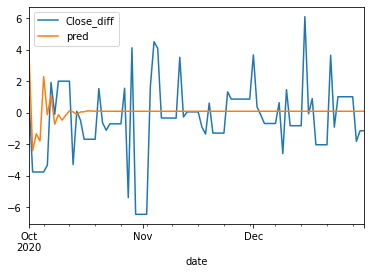

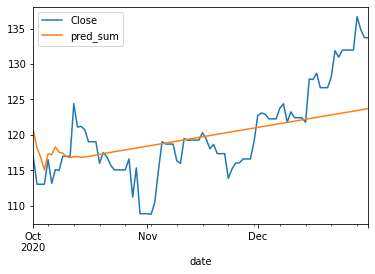

In [15]:
gb_forecaster = fit_model(train_df, target_col="Close_diff", exog_cols = None)
pred_df = predict_ahead(gb_forecaster, test_df, exog_cols = None)
pred_df["pred_sum"] = pred_df["pred"].cumsum() + pred_df.iloc[0].Close
errors["rsme_gb_close_diff"] = compute_test_error(pred_df, y_pred_col = "pred",     y_true_col = "Close_diff")
errors["rsme_gb_close"] = compute_test_error(pred_df, y_pred_col = "pred_sum", y_true_col = "Close")



## Exogenous variables

In [16]:
def best_sentiment_score_lags(df, ticker, num_lags = 30, corr_threshold = 0.1):
    df = df.copy()
    for i in range(0,num_lags):
        df[f"tails_score_lag_{i}"] = df.tails_median_score.shift(i)
    tails_lag_corr = df.corr()[["Close"]].iloc[3:]
    
    fig, ax = plt.subplots(figsize = (10,5))

    tails_lag_corr.plot(ax = ax, title = f"Cross correlation with lagged tails sentiment score: {ticker}")
    plt.xticks(rotation=45)
    plt.show()
    return tails_lag_corr[(tails_lag_corr.abs() > corr_threshold).values]
    

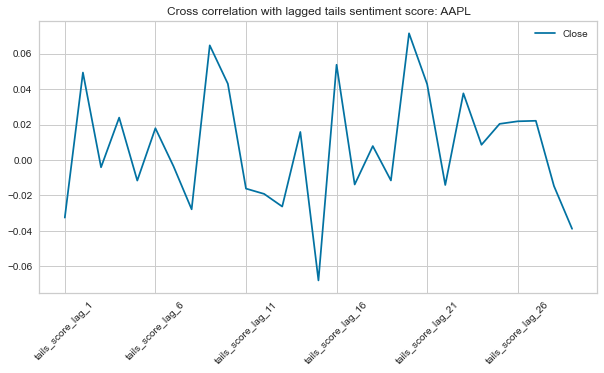

In [161]:


tails_df = train_df[["Close", "tails_median_score"]].copy()
tails_df.Close = tails_df.Close.diff(1) #we differenciate

# We compute the correlation of the change in the close value with the sentiment score at different lags.
# This way we detect how news correlate with change and how many days does it take to make this change
tails_lag_corr = best_sentiment_score_lags(tails_df, ticker, corr_threshold= 0.06)

In [162]:
tails_lag_corr

,Close
tails_score_lag_9,0.064646
tails_score_lag_15,-0.067918
tails_score_lag_20,0.071437


In [163]:
for feature in tails_lag_corr.index:
    lag_value = int(feature.split("_")[-1])
    df[feature] = df.tails_median_score.shift(lag_value)

In [164]:
exog_cols = tails_lag_corr.index.values.tolist() + ["tails_median_score"]

train_df, test_df = train_test_split(df, threshold, )#train_pctg = 0.85)
train_df = train_df.dropna(subset = exog_cols) # we drop the first rows in training where we dont have data.

Test error (rmse): 2.076757931720012
Exog cols : ['tails_score_lag_9', 'tails_score_lag_15', 'tails_score_lag_20', 'tails_median_score']


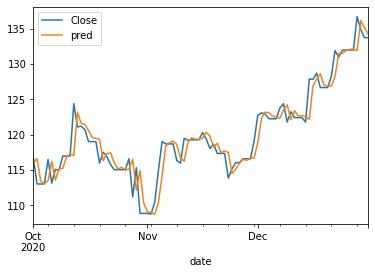

In [21]:
model = pm.arima.ARIMA(order = forecaster.order, suppress_warnings = True)
forecaster = model.fit(train_df.Close, X = train_df[exog_cols])
#forecaster = fit_arima_model(train_df, exog_cols = exog_cols)
pred_df = predict_arima_ahead_update(forecaster, test_df, exog_cols = exog_cols)
errors["rsme_arima_close_exog"] = compute_test_error(pred_df, y_true_col="Close", exog_cols = exog_cols)

Test error (rmse): 2.5839576235709822
Test error (rmse): 13.994190441968575


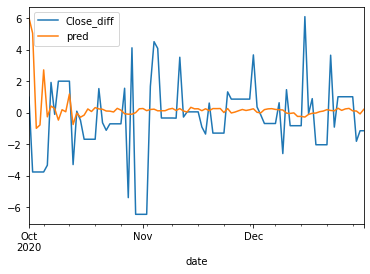

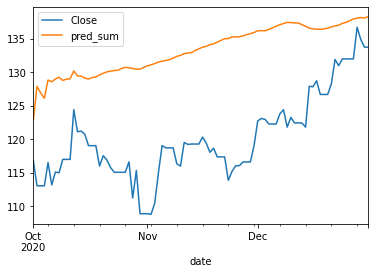

In [22]:
gb_forecaster = fit_model(train_df, target_col="Close_diff", exog_cols = exog_cols)
pred_df = predict_ahead(gb_forecaster, test_df, exog_cols = exog_cols)
pred_df["pred_sum"] = pred_df["pred"].cumsum() + pred_df.iloc[0].Close
errors["rsme_gb_close_diff_exog"] = compute_test_error(pred_df, y_pred_col = "pred",     y_true_col = "Close_diff")
errors["rsme_gb_close_exog"] = compute_test_error(pred_df, y_pred_col = "pred_sum", y_true_col = "Close")



In [23]:
errors

{'rsme_arima_close': 2.0792709932157094,
 'rsme_gb_close_diff': 2.3595054271527944,
 'rsme_gb_close': 4.806295636362065,
 'rsme_arima_close_exog': 2.076757931720012,
 'rsme_gb_close_diff_exog': 2.5839576235709822,
 'rsme_gb_close_exog': 13.994190441968575}

In [24]:

print("Is exog better?",errors["rsme_arima_close"] > errors["rsme_arima_close_exog"])

Is exog better? True


# Classification

We change the approach. We will be predicting whether the stock goes up or down above a certain quantile

In [25]:
import xgboost as xgb

In [165]:
from sklearn.metrics import confusion_matrix
def confusion_matrix_df(df, target_col = "target", pred_col = "pred"):
    # Get unique class labels
    labels = sorted(df[target_col].unique())

    # Compute confusion matrix
    matrix = confusion_matrix(df[target_col], df[pred_col], labels=labels)

    # Create DataFrame from confusion matrix
    df_matrix = pd.DataFrame(matrix, index=labels, columns=labels)

    # Print confusion matrix DataFrame
    df_matrix = df_matrix.add_suffix('_pred')
    df_matrix = df_matrix.rename('{}_target'.format)
    return df_matrix

def bucketize(x, q1, q3):
    if x >= q3:
        return 2
    elif x <= q1:
        return 0
    else:
        return 1

In [166]:
A = df[["Close"]].copy()
A["returns"] = A.Close.pct_change()

non_zero_returns = A[A.returns != 0].returns
q1,q3 = non_zero_returns.quantile([0.25,0.75])

A["target_fake"] = A.returns.apply(bucketize, q1 = q1, q3 = q3)

A["target"] = A.returns.apply(bucketize, q1 = q1, q3 = q3).shift(-1)
A.head().style.background_gradient(axis = 0)

,Close,returns,target_fake,target
date,,,,
2019-01-01 00:00:00,39.480000,nan,1,1.000000
2019-01-02 00:00:00,39.480000,0.000000,1,0.000000
2019-01-03 00:00:00,35.547501,-0.099607,0,2.000000
2019-01-04 00:00:00,37.064999,0.042689,2,1.000000
2019-01-05 00:00:00,37.064999,0.000000,1,1.000000


In [307]:
df["returns"] = df.Close.pct_change().shift(-1).fillna(0)
df["tomorrow_market_closed"] = df.index.weekday.isin([4,5])

threshold = '2020-09-30 23:59:00'
train_df, test_df = train_test_split(df, threshold, )#train_pctg = 0.85)


In [168]:
def best_score_lags(df, variable, ticker, num_lags = 30, corr_threshold = 0.1):
    score_lags = df[[variable]].copy()
    for i in range(1,num_lags):
        score_lags[f"{variable}_lag_{i}"] = df[variable].shift(i)
    
    score_lag_corr = score_lags.corr()[[variable]].iloc[1:]
    
    fig, ax = plt.subplots(figsize = (10,5))
    score_lag_corr.plot(ax = ax, title = f"Cross correlation with lagged {variable} score: {ticker}")
    plt.xticks(rotation=45)
    plt.show()
    filtered_score_lags_corr = score_lag_corr[(score_lag_corr.abs() > corr_threshold).values]
    return filtered_score_lags_corr

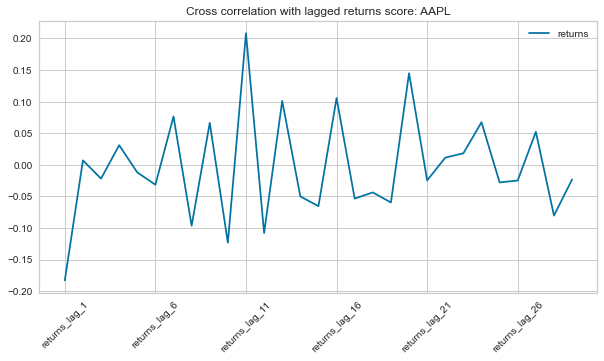

,returns
returns_lag_1,-0.182783
returns_lag_10,-0.123265
returns_lag_11,0.208291
returns_lag_12,-0.107897
returns_lag_13,0.101304
returns_lag_16,0.105842
returns_lag_20,0.144992


In [169]:
score_lags_corr = best_score_lags(train_df, "returns", ticker)
score_lags_corr

In [170]:
for feature in score_lags_corr.index:
    lag_value = int(feature.split("_")[-1])
    df[feature] = df.returns.shift(lag_value)

In [218]:
q_tails = 0.15
print("Quantiles", q_tails, 1 - q_tails)
non_zero_returns = df[df.returns != 0].returns
q1,q3 = non_zero_returns.quantile([q_tails, 1 - q_tails])

Quantiles 0.15 0.85


In [219]:
df["target"] = df.returns.apply(bucketize, q1 = q1, q3 = q3).shift(-1) # Super important shifting here

(0.0, 100.0)

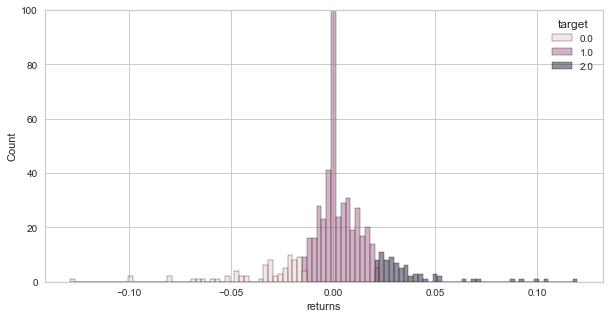

In [220]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(df, x = "returns", hue = df.target.shift(1))
plt.ylim(0, 100)

In [221]:
y_col = "target"
X_cols_stock = ["returns"] + score_lags_corr.index.tolist()
X_cols_news  =  exog_cols
X_cols_mix   = X_cols_stock + X_cols_news


cols = [y_col] + X_cols_news

#threshold = '2020-09-30 23:59:00'
train_df, test_df = train_test_split(df, threshold, )#train_pctg = 0.85)


train_df = train_df.dropna(subset = cols)
test_df  =  test_df.dropna(subset = cols)

y_train, y_test = train_df[y_col], test_df[y_col]

X_train_news,  X_test_news  = train_df[X_cols_news], test_df[X_cols_news]
X_train_stock, X_test_stock = train_df[X_cols_stock], test_df[X_cols_stock]
X_train_mix,   X_test_mix   = train_df[X_cols_mix], test_df[X_cols_mix]


In [222]:
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.utils.class_weight import compute_sample_weight



from yellowbrick.classifier import ROCAUC
label_encoding = {0: "down", 1: "stay", 2: "up"}
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest, **kwargs):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder=label_encoding, **kwargs)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
 

In [270]:

def simple_xgb_clf_fit(X_train, y_train, X_test, y_test):
    
    clf = xgb.XGBClassifier(objective="multi:softprob",
                            eval_metric = "auc",)
    
    #class_weights = {0 : 0.4, 1 : 0.2, 2: 0.4}

    sample_weights = compute_sample_weight(class_weight= "balanced", y=y_train)
    eval_set = [(X_train, y_train), ((X_test, y_test))]
    
    clf.fit(X_train, y = y_train,
            sample_weight = sample_weights,
            #eval_set = eval_set,
            verbose = False)
    return clf

stock_clf = simple_xgb_clf_fit(X_train_stock, y_train, X_test_stock, y_test)
news_clf  = simple_xgb_clf_fit(X_train_news , y_train, X_test_news , y_test)
mix_clf   = simple_xgb_clf_fit(X_train_mix  , y_train, X_test_mix  , y_test)


In [268]:
def random_search_xgb_clf_fit(X_train, y_train, X_test, y_test):

    # A parameter grid for XGBoost
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5],
            'learning_rate' : [0.2, 0.1, 0.01],
            'n_estimators' : [200, 400, 600],
            }

    model = xgb.XGBClassifier(objective="multi:softprob",
                              eval_metric = "auc")
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


    folds = 4
    param_comb = 60

    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    #ts_split = TimeSeriesSplit(n_splits=folds)

    random_search = RandomizedSearchCV(model, 
                                       param_distributions=params, 
                                       n_iter=param_comb,
                                       scoring = "f1_weighted",
                                       n_jobs=4,
                                       cv= skf.split(X_train,y_train),
                                       verbose=1,
                                       random_state=1001 )

    # Here we go
    start_time = timer(None) # timing starts from this point for "start_time" variable
    random_search.fit(X_train, y_train, sample_weight = sample_weights)
    timer(start_time)
    return random_search

In [269]:
stock_rs_clf = random_search_xgb_clf_fit(X_train_stock, y_train, X_test_stock, y_test)
news_rs_clf  = random_search_xgb_clf_fit(X_train_news , y_train, X_test_news , y_test)
mix_rs_clf   = random_search_xgb_clf_fit(X_train_mix  , y_train, X_test_mix  , y_test)

Fitting 4 folds for each of 60 candidates, totalling 240 fits

 Time taken: 0 hours 0 minutes and 23.01 seconds.
Fitting 4 folds for each of 60 candidates, totalling 240 fits

 Time taken: 0 hours 0 minutes and 22.89 seconds.
Fitting 4 folds for each of 60 candidates, totalling 240 fits

 Time taken: 0 hours 0 minutes and 29.1 seconds.


In [271]:
models = {"stock" : stock_clf, 
          "news"  : news_clf,
          "mix"   : mix_clf,
          "stock_rs" : stock_rs_clf,
          "news_rs" : news_rs_clf,
          "mix_rs" : mix_rs_clf,
         }

In [272]:
pred_df = test_df[[y_col]].copy()

In [273]:
pred_df["stock_pred"] = stock_clf.predict(X_test_stock)
pred_df["stock_rs_pred"] = stock_clf.predict(X_test_stock)

pred_df["news_pred"] = news_clf.predict(X_test_news)
pred_df["news_rs_pred"] = news_rs_clf.predict(X_test_news)

pred_df["mix_pred"] = mix_clf.predict(X_test_mix)
pred_df["mix_rs_pred"] = mix_rs_clf.predict(X_test_mix)

pred_df = pred_df.replace(label_encoding)

cm_stock_df = confusion_matrix_df(pred_df, pred_col = "stock_pred")
cm_stock_rs_df = confusion_matrix_df(pred_df, pred_col = "stock_rs_pred")

cm_news_df = confusion_matrix_df(pred_df, pred_col = "news_pred")
cm_news_rs_df = confusion_matrix_df(pred_df, pred_col = "news_rs_pred")

cm_mix_df = confusion_matrix_df(pred_df, pred_col = "mix_pred")
cm_mix_rs_df = confusion_matrix_df(pred_df, pred_col = "mix_rs_pred")

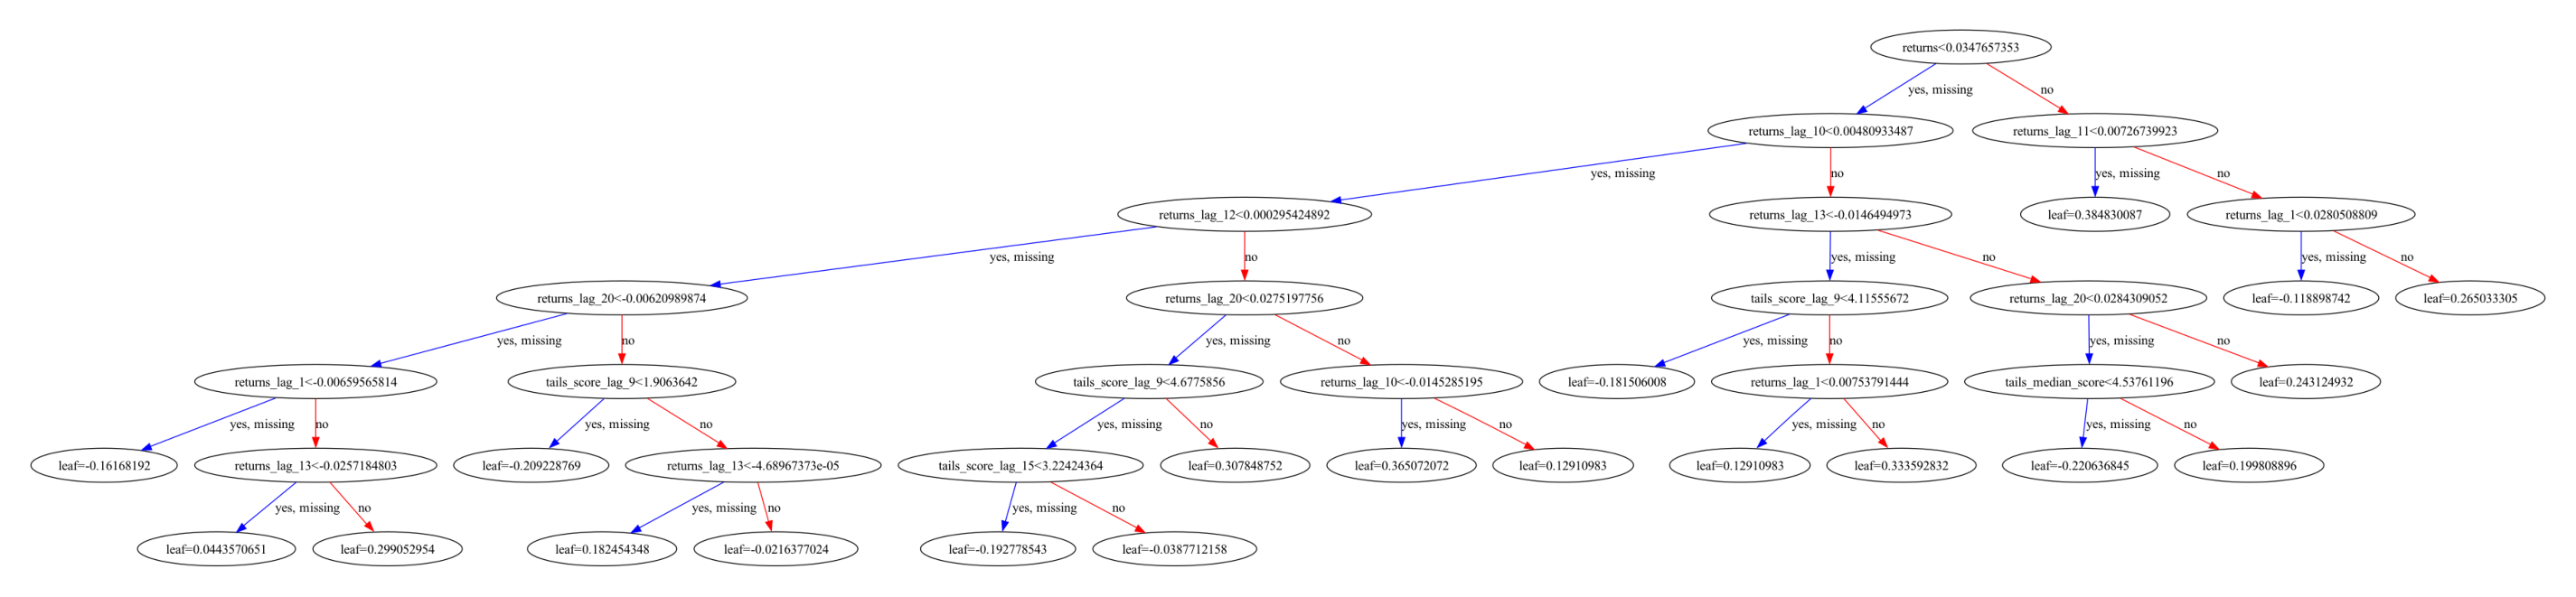

In [274]:
fig, ax = plt.subplots(figsize = (12,12), dpi = 300)
xgb.plot_tree(mix_clf, ax = ax)
plt.show()

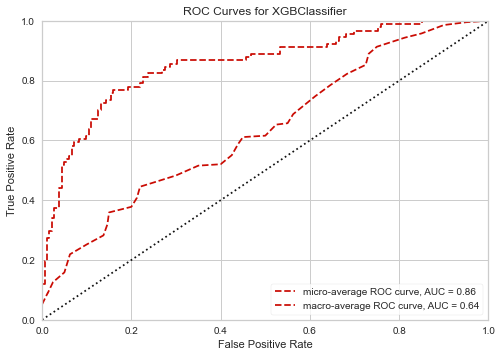

In [275]:
stock_visualizer = plot_ROC_curve(stock_clf,
                            X_train_stock, y_train,
                            X_test_stock, y_test,
                            per_class = False)

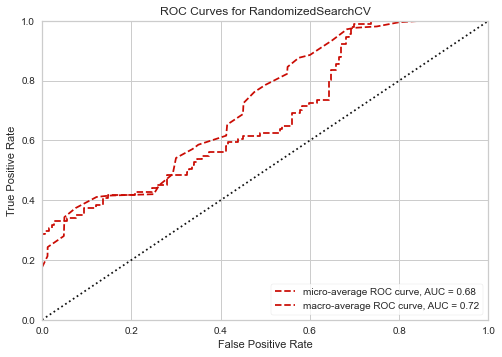

In [226]:
stock_rs_visualizer = plot_ROC_curve(stock_rs_clf,
                            X_train_stock, y_train,
                            X_test_stock, y_test,
                            per_class = False)

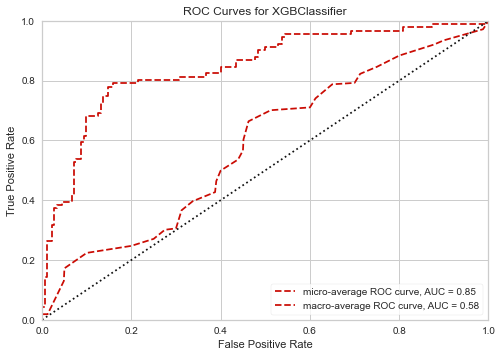

In [267]:
news_visualizer = plot_ROC_curve(news_clf,
                                X_train_news, y_train,
                                X_test_news, y_test,
                                per_class = False)

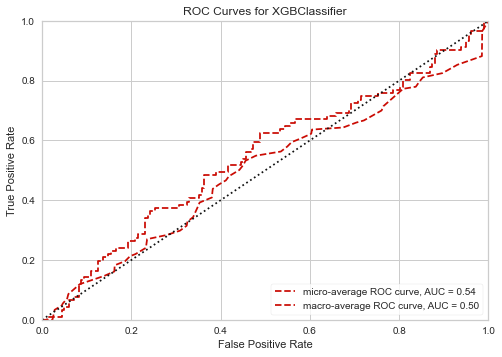

In [216]:
random_search_visualizer = plot_ROC_curve(news_rs_clf.best_estimator_,
                                X_train_news, y_train,
                                X_test_news, y_test,
                                per_class = False)

In [276]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_dict = {}
f1_score_dict = {}

for pred_var in pred_df.columns[1:]:
    accuracy_dict[f"{pred_var}"] = accuracy_score(pred_df.target, pred_df[pred_var], normalize=True)
    f1_score_dict[f"{pred_var}"] = f1_score(pred_df.target, pred_df[pred_var], average="weighted")

In [277]:
scores_df = pd.DataFrame([accuracy_dict, f1_score_dict], index = ["accuracy", "f1_score"]).T
scores_df.style.background_gradient()

,accuracy,f1_score
stock_pred,0.725275,0.679107
stock_rs_pred,0.725275,0.679107
news_pred,0.692308,0.653897
news_rs_pred,0.670330,0.652433
mix_pred,0.725275,0.675294
mix_rs_pred,0.615385,0.639345


In [147]:
scores_df = pd.DataFrame([accuracy_dict, f1_score_dict], index = ["accuracy", "f1_score"]).T
scores_df.style.background_gradient()

,accuracy,f1_score
stock_pred,0.659341,0.654960
stock_rs_pred,0.659341,0.654960
news_pred,0.692308,0.653897
news_rs_pred,0.670330,0.652433
mix_pred,0.736264,0.705623
mix_rs_pred,0.637363,0.619901


In [278]:
cm_stock_df

,down_pred,stay_pred,up_pred
down_target,2,7,0
stay_target,4,64,3
up_target,0,11,0


In [279]:
cm_mix_df

,down_pred,stay_pred,up_pred
down_target,1,8,0
stay_target,4,65,2
up_target,2,9,0


In [280]:
cm_rs_df

,down_pred,stay_pred,up_pred
down_target,0,9,0
stay_target,6,58,7
up_target,3,8,0


In [ ]:
import shap

model_ = stock_clf
X = X_test_stock
pred = model_.predict(X, output_margin=True)
explainer = shap.TreeExplainer(model_)
shap_values = explainer.shap_values(X)


shap.summary_plot(shap_values, X)
